In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector
import re

In [2]:
amsterdam_weekdays = pd.read_csv('datas/amsterdam_weekdays.csv')
amsterdam_weekends = pd.read_csv('datas/amsterdam_weekends.csv')

In [3]:
print(amsterdam_weekdays.shape)
print(amsterdam_weekends.shape)

(1103, 20)
(977, 20)


In [4]:
def combine(csv_1,col_1,csv_2,col_2):
    csv_1['weekdays'] = col_1
    csv_2['weekdays'] = col_2
    csv_1.drop(columns = ['Unnamed: 0'],inplace=True)
    csv_2.drop(columns = ['Unnamed: 0'],inplace=True)
    merged = pd.concat([csv_1, csv_2])
    return merged

In [5]:
amsterdam = combine(amsterdam_weekdays,'weekdays',amsterdam_weekends,'weekends')

In [6]:
amsterdam['Location Co-ordinates'] = amsterdam.apply(lambda row: (row['lat'], row['lng']), axis=1)

In [7]:
amsterdam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 976
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     2080 non-null   float64
 1   room_type                   2080 non-null   object 
 2   room_shared                 2080 non-null   bool   
 3   room_private                2080 non-null   bool   
 4   person_capacity             2080 non-null   float64
 5   host_is_superhost           2080 non-null   bool   
 6   multi                       2080 non-null   int64  
 7   biz                         2080 non-null   int64  
 8   cleanliness_rating          2080 non-null   float64
 9   guest_satisfaction_overall  2080 non-null   float64
 10  bedrooms                    2080 non-null   int64  
 11  dist                        2080 non-null   float64
 12  metro_dist                  2080 non-null   float64
 13  attr_index                  2080 n

In [143]:
amsterdam

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,weekdays,Location Co-ordinates
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,weekdays,"(52.41772, 4.90569)"
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,weekdays,"(52.37432, 4.90005)"
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,weekdays,"(52.36103, 4.97512)"
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,weekdays,"(52.37663, 4.89417)"
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,weekdays,"(52.37508, 4.90051)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,473.132894,Entire home/apt,False,False,2.0,False,0,0,9.0,98.0,...,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629,weekends,"(52.36629, 4.86742)"
973,491.645771,Entire home/apt,False,False,3.0,False,0,0,10.0,98.0,...,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412,weekends,"(52.38412, 4.88066)"
974,1812.855904,Entire home/apt,False,False,4.0,False,0,0,8.0,84.0,...,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794,weekends,"(52.35794, 4.90688)"
975,399.315727,Entire home/apt,False,False,2.0,False,0,0,9.0,89.0,...,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639,weekends,"(52.34639, 4.86056)"


In [10]:
amsterdam.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,573.112795,2.781731,0.283173,0.105288,9.465865,94.514423,1.292308,2.825052,1.089367,269.064730,14.246499,335.712818,26.097566,4.890472,52.364637
std,430.658406,1.032634,0.450648,0.306999,0.813421,6.350874,0.736683,2.082573,0.831669,195.193411,10.335158,226.473943,17.720931,0.038736,0.018885
min,128.887118,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.015045,0.036517,40.890060,2.164941,50.823991,3.545205,4.775500,52.290310
25%,331.825745,2.000000,0.000000,0.000000,9.000000,92.000000,1.000000,1.349250,0.464639,130.557523,6.913108,165.528716,12.739227,4.870400,52.354565
50%,460.244183,2.000000,0.000000,0.000000,10.000000,96.000000,1.000000,2.329951,0.861928,208.577946,11.044224,263.073705,20.767760,4.889430,52.365340
75%,686.441075,4.000000,1.000000,0.000000,10.000000,99.000000,2.000000,3.627072,1.504676,378.208244,20.026378,456.506331,35.437042,4.906743,52.375255
max,8130.668104,6.000000,1.000000,1.000000,10.000000,100.000000,5.000000,11.195932,4.411915,1888.737455,100.000000,1435.102401,100.000000,5.010770,52.423480


# <span style="color:#339999; font-size:1em;">AMSTERDAM : PRICES DISTRIBUTION</span>

# <span style="color:#a2b3b2; font-size:0.75em;">DISTRIBUTION OF PRICES

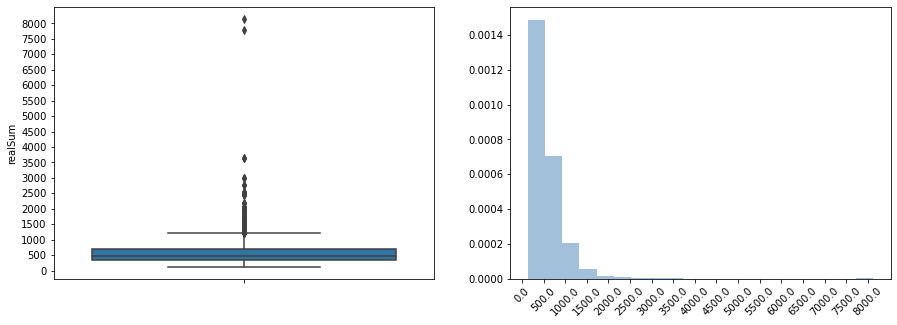

In [35]:
warnings.filterwarnings('ignore')

plt.figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(y='realSum', data=amsterdam, ax=axs[0])
axs[0].set_yticks(np.arange(0,max(amsterdam['realSum']),500))

axs[1].hist(amsterdam['realSum'], bins=20, alpha=0.5, color='steelblue', density=True)
axs[1].set_xticklabels(np.arange(0,max(amsterdam['realSum']),500),rotation=45)
axs[1].set_xticks(np.arange(0,max(amsterdam['realSum']),500))

plt.show()

# <span style="color:#2c7873; font-size:0.5em;">FINDINGS : </span>
<p style="color:#2c7873; font-size:1em;">
    From the above plots it can be seen that the Majority of Prices of AirBnb's in Amsterdam range from 250 to 750. Looking at the shape of the distribution, it is a Right-Skewed Ditributtion, and we also have a few High outliers.
</p>

# <span style="color:#a2b3b2; font-size:0.75em;">DISTRIBUTION OF NUMERIC VARIABLES

In [115]:
list(amsterdam.select_dtypes(include=['int64','float64']).columns)[1]

'person_capacity'

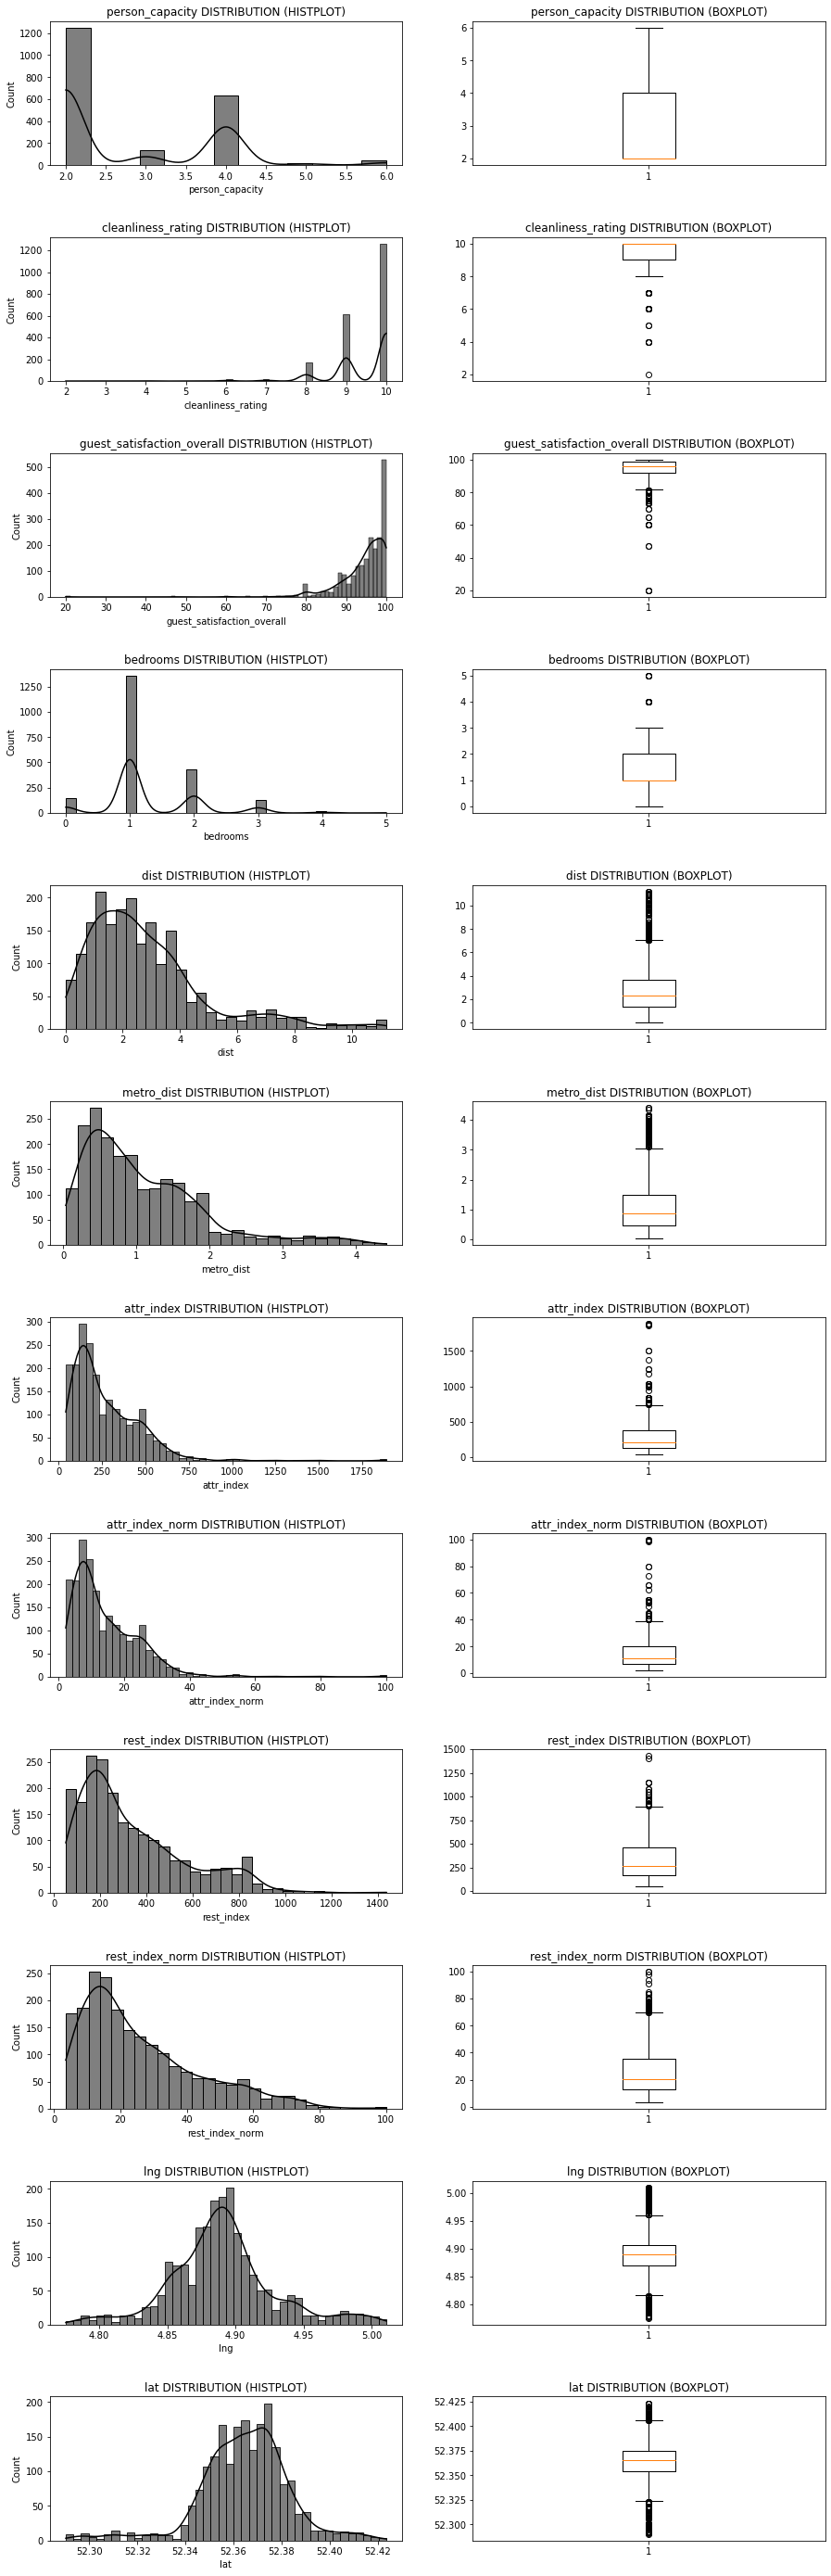

In [142]:
amsterdam_numerical_features = list(amsterdam.select_dtypes(include=['int64','float64']).columns[i] for i in [1,4,5,6,7,8,9,10,11,12,13,14])

def amsterdam_numeric_disstribution_plotter(feature,color,row):
    sns.histplot(data=amsterdam[feature],ax=axes[row,0],kde=True,color=color)
    axes[row,0].set_title(str(feature)+" DISTRIBUTION (HISTPLOT)")
    axes[row,1].boxplot(amsterdam[feature])
    axes[row,1].set_title(str(feature)+" DISTRIBUTION (BOXPLOT)")
    
    
plt.figure
fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(15, 50))
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[0] , '000000' , 0)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[1] , '000000' , 1)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[2] , '000000' , 2)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[3] , '000000' , 3)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[4] , '000000' , 4)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[5] , '000000' , 5)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[6] , '000000' , 6)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[7] , '000000' , 7)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[8] , '000000' , 8)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[9] , '000000' , 9)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[10] , '000000' , 10)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[11] , '000000' , 11)

plt.subplots_adjust(hspace=0.50)
plt.show()


# <span style="color:#2c7873; font-size:0.5em;">IMPORTANT FINDINGS : </span>
<p style="color:#2c7873; font-size:1em;">
    Room Capacity : For AirBnb listings is Amsterdam, Majority of rooms either have the capacity for 4 People, or for Two people. Generalizing it, roughly 75% of listings on our data had capacity for 2 - 4 people. <br><br>
Cleanliness Rating : Data suggests that almost all the Listings have recieved a cleanliness rating greater than 8. Even the listings with rating 7 were outliers in our data. Thus the overall cleanliness rating of Amsterrdam Listings is quite high.<br><br>
Guest Satisfaction Overall : The Guest satisfaction skews to the left, meaning that most listings achieved satisfaction scores above 80. In our data, satisfaction scores of less that 80 were low outliers <br><br> 
Bedrooms : The number of bedrooms in the majority of listings range from studio apartments to 3 bedrooms. Noticing that most of the listings had capacity of 2-4 people, this distribution of number of bedrooms can relate to it. <br><br>
dist : Majority of listings are within 7 km's of the city centre. <br><br>
metro_dist : Majority of listings are within 3 km's from the nearest metro stations.<br><br>

</p>

# <span style="color:#a2b3b2; font-size:0.75em;">VARIABLES RELATION WITH PRICE

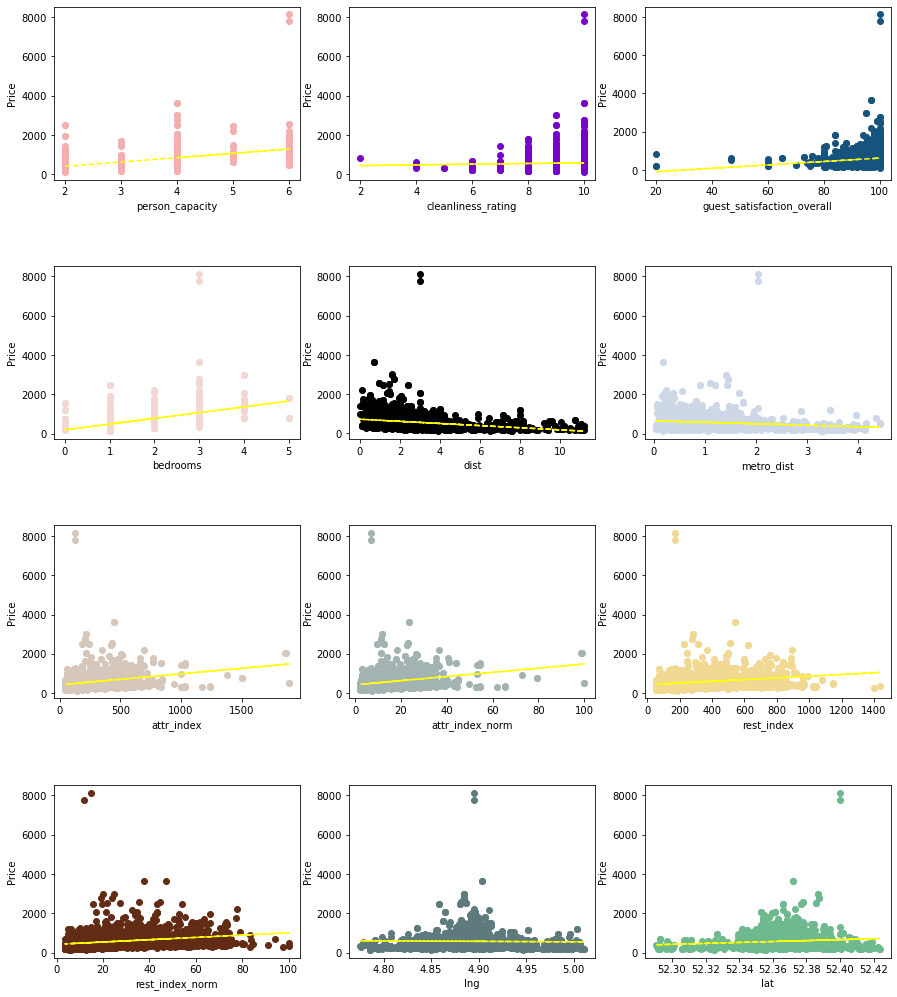

In [172]:
amsterdam_numerical_features = list(amsterdam.select_dtypes(include=['int64','float64']).columns[i] for i in [1,4,5,6,7,8,9,10,11,12,13,14])

def amsterdam_numeric_plotter(x,y,feature,color):
    axes[x,y].scatter(y=amsterdam["realSum"], x=amsterdam[feature],c=color)
    trend_line = np.poly1d(np.polyfit(amsterdam[feature], amsterdam["realSum"], 1))
    axes[x,y].plot(amsterdam[feature], trend_line(amsterdam[feature]), "r--",c='yellow')
    axes[x,y].set_ylabel("Price")
    axes[x,y].set_xlabel(feature)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 17.5))

amsterdam_numeric_plotter(0 , 0 , amsterdam_numerical_features[0] , '#f1afaf' )
amsterdam_numeric_plotter(0 , 1 , amsterdam_numerical_features[1] , '#7804c8' )
amsterdam_numeric_plotter(0 , 2 , amsterdam_numerical_features[2] , '#16537e' )
amsterdam_numeric_plotter(1 , 0 , amsterdam_numerical_features[3] , '#f1d8d5' )
amsterdam_numeric_plotter(1 , 1 , amsterdam_numerical_features[4] , '#000000' )
amsterdam_numeric_plotter(1 , 2 , amsterdam_numerical_features[5] , '#cdd7e5' )
amsterdam_numeric_plotter(2 , 0 , amsterdam_numerical_features[6] , '#d6c7bd' )
amsterdam_numeric_plotter(2 , 1 , amsterdam_numerical_features[7] , '#a2b3b2' )
amsterdam_numeric_plotter(2 , 2 , amsterdam_numerical_features[8] , '#f1d993' )
amsterdam_numeric_plotter(3 , 0 , amsterdam_numerical_features[9] , '#622c14' )
amsterdam_numeric_plotter(3 , 1 , amsterdam_numerical_features[10] , '#5e7a7d' )
amsterdam_numeric_plotter(3 , 2 , amsterdam_numerical_features[11] , '#6fb98f' )

plt.subplots_adjust(hspace=0.5)

# <span style="color:#a2b3b2; font-size:0.75em;">CORELLATION AMONG INPUTS and WITH OUTPUTS

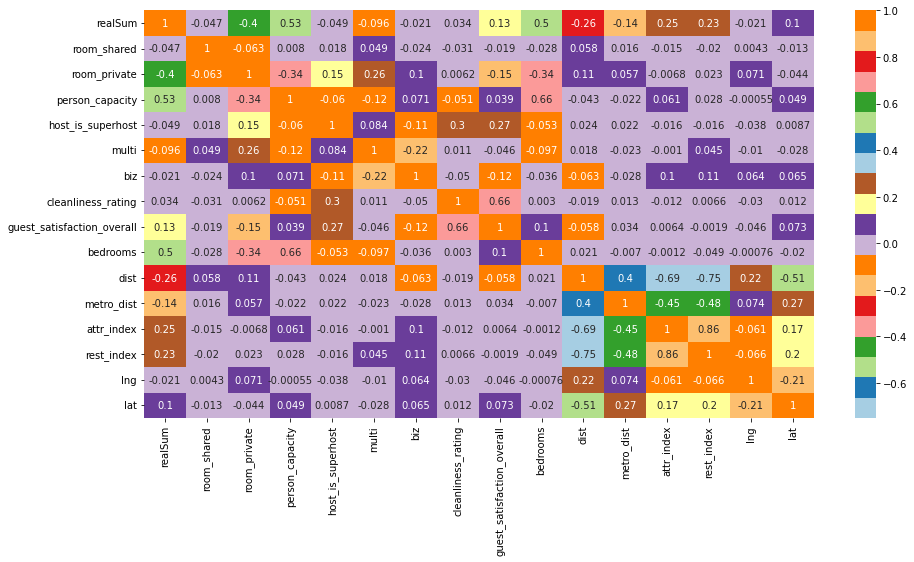

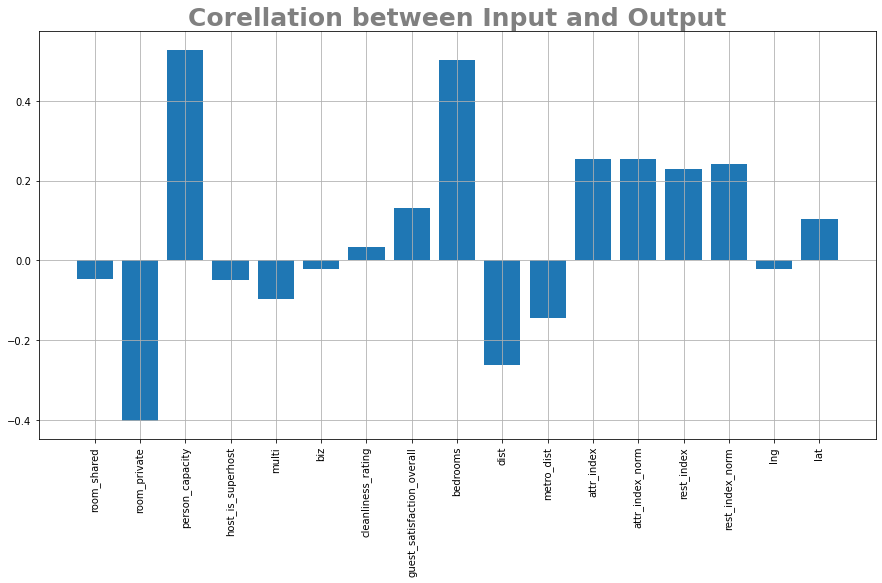

In [144]:
plt.figure
fig, axs = plt.subplots(1, 1, figsize=(15, 7.5))
sns.heatmap(amsterdam.drop(columns=['attr_index_norm','rest_index_norm']).corr(),cmap=sns.color_palette("Paired",20),annot=True)

fig2, axs2 = plt.subplots(1, 1, figsize=(15, 7.5))
axs2.bar(x = ((amsterdam.drop(columns=['realSum'])).corrwith(amsterdam['realSum'])).index, height = (((amsterdam.drop(columns=['realSum'])).corrwith(amsterdam['realSum'])).values))
axs2.set_xticklabels(((amsterdam.drop(columns=['realSum'])).corrwith(amsterdam['realSum'])).index,rotation=90)
axs2.set_title('Corellation between Inputs and Output',fontsize=25,fontweight='bold',color='Gray')
plt.grid(True)
plt.show()

# <span style="color:#a2b3b2; font-size:0.75em;">CATEGORICAL & BINARY FEATURES, THEIR COUNTS AND RELATION WITH OUTPUT THROUGH BOXPLOT

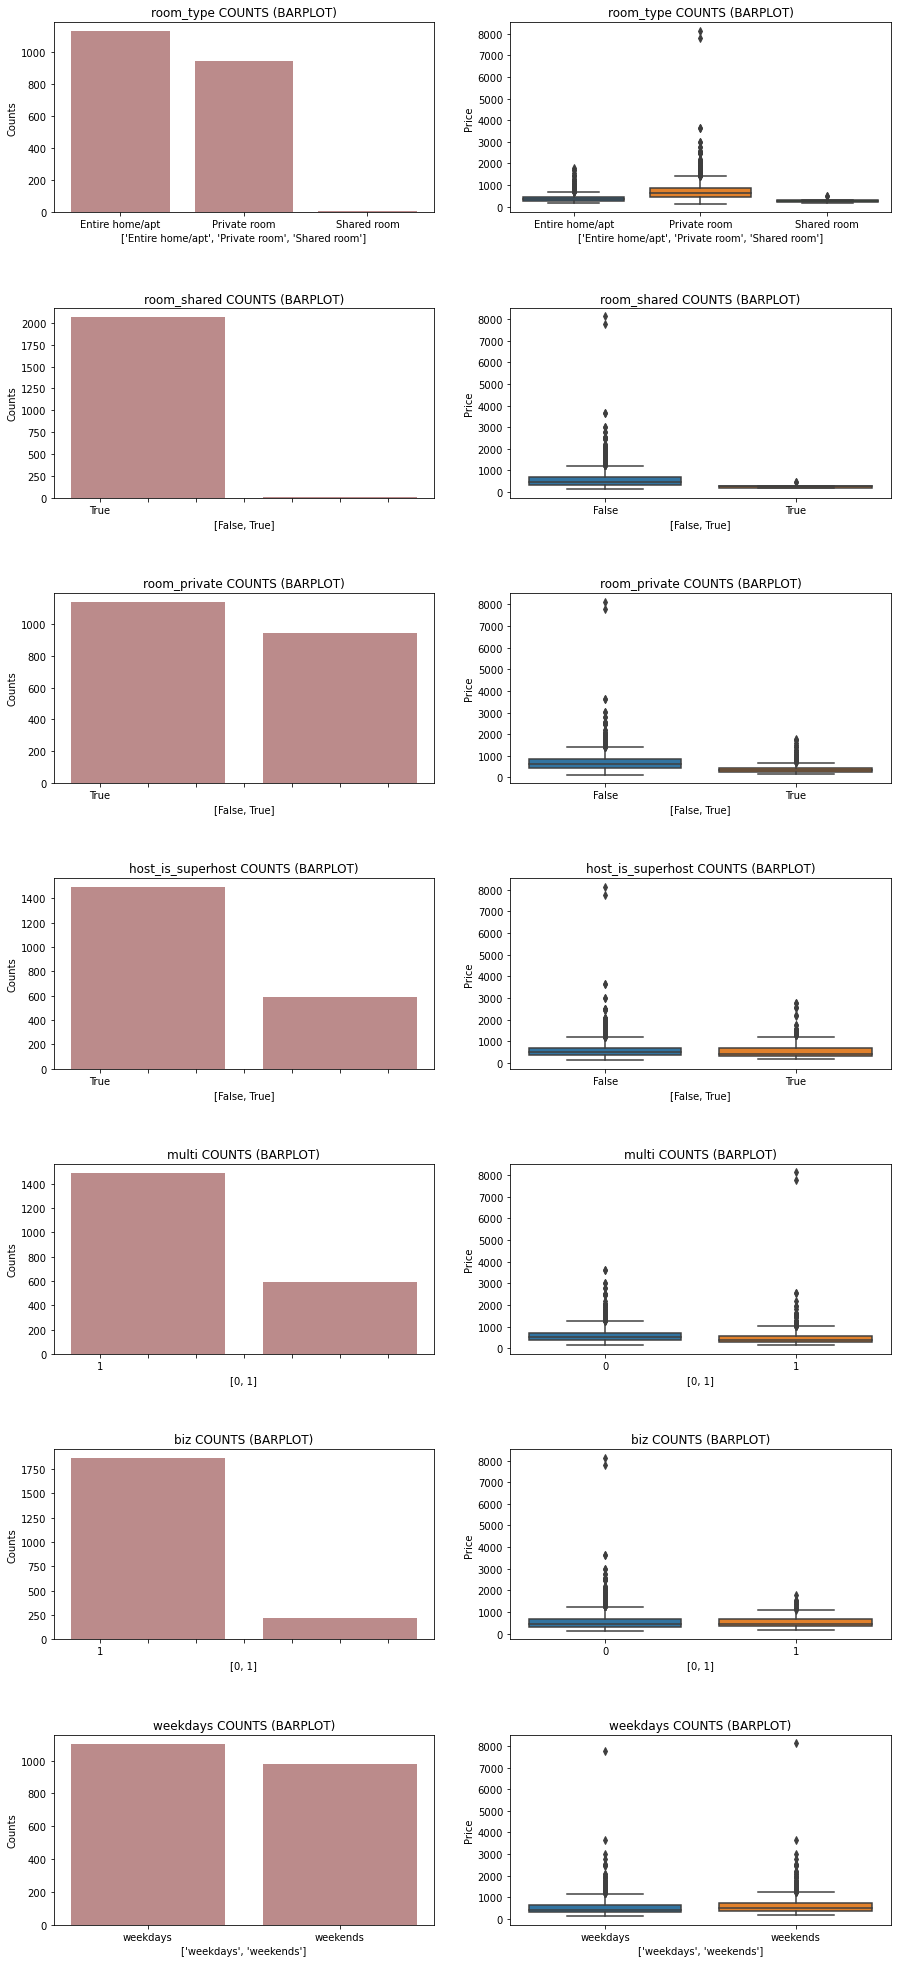

In [202]:
amsterdam_categorical_features = ['room_type','room_shared','room_private','host_is_superhost','multi','biz','weekdays']

def amsterdam_categorical_distribution_plotter(feature,color,row):
    axes[row,0].bar(x = list(amsterdam[feature].value_counts().index), height=list(amsterdam[feature].value_counts().values),color=color)
    axes[row,0].set_ylabel("Counts")
    axes[row,0].set_xticklabels(list(amsterdam[feature].value_counts().index))
    axes[row,0].set_xlabel(list(amsterdam[feature].value_counts().index))
    axes[row,0].set_title(str(feature)+" COUNTS (BARPLOT)")
    
    sns.boxplot(x = feature ,y = 'realSum', data = amsterdam, ax = axes[row,1])
    axes[row,1].set_ylabel("Price")
    axes[row,1].set_xticklabels(list(amsterdam[feature].value_counts().index))
    axes[row,1].set_xlabel(list(amsterdam[feature].value_counts().index))
    axes[row,1].set_title(str(feature)+" COUNTS (BARPLOT)")

    
plt.figure
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 35))
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[0] , '#bb8b8b' , 0)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[1] , '#bb8b8b' , 1)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[2] , '#bb8b8b' , 2)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[3] , '#bb8b8b' , 3)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[4] , '#bb8b8b' , 4)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[5] , '#bb8b8b' , 5)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[6] , '#bb8b8b' , 6)



plt.subplots_adjust(hspace=0.50)
plt.show()
